# Temperature Control Lab, step identification

The [temperature control lab](https://apmonitor.com/pdc/index.php/Main/ArduinoTemperatureControl) or TCLab is a laboratory device used for thermal projects. It can be used to simulate and develop thermal control and regulation systems. The TCLab features a feedback control application with an Arduino, an LED, 2 heaters and 2 temperature sensors:  
- one heater will represent the TCS heating elements used for temperature control. 
- another will represent external disturbances such as solar radiation in the Cubesat application.

During this tutorial we will start using this card and carry out temperature measurements on control steps. The aim is to identify a dynamic model that can be used to synthesise the control.

## The TCLab Arduino Package

The Temperature Control Laboratory hardware consists of five components:

1. Arduino microcontroller board (Arduino Uno, Arduino Leonardo, or equivalents).

2. The Temperature Control Laboratory plug-in board (also known as a shield).

3. Five watt USB power supply.

4. 5.5mm to USB power supply cable.

5. USB 2.0 data cable. (w/mini-USB connector for Arduino Uno, or micro-USB cable for Arduino 
Leonardo.)

*TCLab kit:*
![TCLab](figures/B.00-arduino_lab_kit.png)

#### The main TCLab components
Thermistors: These are temperature sensors, there are two thermistors on a TCLab to measure at two different points.
The TCLab is equipped with 2 heaters to heat the system for temperature control experiments.
#### Assembly 
The TCLab is attached to the inputs of the arduino board (sort of metal teeth), then a blue cable connects the micro USB type B port on the arduino board to the USBA port on the PC. The TCLab is powered via the mains and its DC power port.
#### Setup
Before going further, be sure to complete the steps outlined under *Hardware setup* as described in TCLab [README](https://github.com/jckantor/TCLab/blob/master/README.rst). Mac OS users may need to install a serial driver available [here](https://github.com/adrianmihalko/ch340g-ch34g-ch34x-mac-os-x-driver). Normally the TCLab shield will already be mounted on the Arduino board, and the firmware driver will have been loaded on to the Arduino.



## Getting to grips with the Arduino code

The Arduino sketch, when downloaded and installed on a compatible Arduino device, supports the Temperature Control Lab. The sketch is used in conjunction with the compatible Python library TCLab for programmable control of the Temperature Control Lab with Python via Python Serial library.

> Read the Arduino .ino code in C language from the file [here](https://github.com/jckantor/TCLab-sketch/blob/master/TCLab-sketch/TCLab-sketch.ino). Describe its structure and, in particular, its temporal execution. Copy below the part of the code that initalises the microntroleur at start-up, as well as the main loop.  

**Note:** For a better understanding, read the following page [Basic structure of an arduino code](https://arduinogetstarted.com/tutorials/arduino-code-structure)

:::{dropdown} Answers  
`setup()`: The setup function starts configurations with analogReference(EXTERNAL), then initializes serial communication using Serial.begin(baud) where baud is the communication speed. There is a while() that waits for serial communication to be established. This empty loop is necessary to ensure that the program doesn't try to communicate via the serial port until it's ready. 
The pinQ1 and pinQ2 outputs are initialized to a value of 0 using analogWrite, which initially switches off the 2 radiators. 

```
// arduino startup
void setup() {
  analogReference(EXTERNAL);
  Serial.begin(baud); 
  while (!Serial) {
    ; // wait for serial port to connect.
  }
  analogWrite(pinQ1, 0);
  analogWrite(pinQ2, 0);
}
```

`loop()`: This function is the main execution function and is executed in a loop, at each iteration of the loop it calls parseSerial() to analyze the data received via the serial port, then it calls dispatchCommand() to execute the commands. The checkTemp() function is written as a comment and is inactive.
 
``` 
// arduino main event loop
void loop() {
  parseSerial();
  dispatchCommand();
  //checkTemp();
}
```
:::

### Compiling and uploading code to an Arduino microcontroller

Complete the following steps:
- install Arduino software (if not done)
- if necessary upload the Tclab [TCLab-sketch.ino](https://github.com/jckantor/TCLab-sketch/blob/master/TCLab-sketch/TCLab-sketch.ino) code in the Arduino microcontroller (select the right Arduino card before with `Tools/Card` the right card type)
- select the communication port `Tools/Port`
- open the serial monitor `Tools/Serial Monitor`  


### Reading Temperatures with serial monitor

The temperature sensors on the temperature control lab can be acccessed with the attributes `T1` and `T2`.  
> In the serial monitor, send orders `T1` and `T2` what do you observe? Can you find the corresponding part of the code? 

In [2]:
:::{dropdown} Answers  

The `dispatchcommand()` function in the main execution loop executes commands (cmd) received over the serial link from the serial monitor or the python environment. 

```
void dispatchCommand(void) {
[...]
  else if (cmd == "T1") {
    sendFloatResponse(readTemperature(pinT1));
  }
[...]
  else if (cmd == "T2") {
    sendFloatResponse(readTemperature(pinT2));
  }
```

In our case, it executes commands T1 or T2 and calls the functions below: 
- Reading an analogue input with analogue-to-digital conversion and scaling. Averaging several acquisitions reduces sensitivity to measurement noise. 

``` 
// return average  of n reads of thermister temperature in °C
inline float readTemperature(int pin) {
  float degC = 0.0;
  for (int i = 0; i < n; i++) {
    degC += analogRead(pin) * 0.322265625 - 50.0;    // use for 3.3v AREF
    //degC += analogRead(pin) * 0.170898438 - 50.0;  // use for 1.75v AREF
  }
  return degC / float(n);
}
```

- The averaged value is sent via the serial link. 
```
void sendFloatResponse(float val) {
  Serial.println(String(val, 3));
}
```
:::

SyntaxError: invalid syntax (3152461196.py, line 1)

### Setting Heaters

Both heaters can be set between 0 to 100% power with the functions `Q1 x` ou `Q2 x` (where x is between 0 and 100). The device firmware limits the heaters to a range of 0 to 100%. The current value of attributes may be accessed via
    
> Using the serial monitor, set source Q1 to 100% heat and observe the change in temperatures T1 and T2. What do you observe? **Stop all the heaters** with the `X` command.
 
    
**Note A:**  
1. The led on the temperature control laboratory will turns from dim to bright when either heater is on.
2. Closing the TCLab instance turns the heaters off.
3. The power level of the two heaters may be different. Current versions of the firmware limit maximum power of first heater to 4 watts, and maximum power of the second heater to 2 watts.
4. In addition to the constraints imposed by the firmware, the power supply may not be capable of providing all of the power needed to operate both heaters at 100%
5. The values retrieved from these functions may be different than the values set due to the power limits enforced by the device firmware.

**Note B:**  
Each command returns a result string.  

| Command | Action  |
| -:- | -:-  |
|  A |        software restart. Returns "Start"|  
|  LED float | set LED to float for 10 sec. range 0 to 100. Returns actual float  |
|  P1 float  | set pwm limit on heater 1, range 0 to 255. Default 200. Returns P1.  |
|  P2 float  | set pwm limit on heater 2, range 0 to 255. Default 100. Returns P2.  |
|  Q1 float  | set Heater 1, range 0 to 100. Returns value of Q1.  |
|  Q2 float  | set Heater 2, range 0 to 100. Returns value of Q2.  |
|  Q1B float | set Heater 1, range 0 to 100. Returns value of Q1 as a 32-bit float.  |
|  Q2B float | set Heater 2, range 0 to 100. Returns value of Q2 as a 32-bit float.  |
|  R1  |      get value of Heater 1, range 0 to 100  |
|  R2   |     get value of Heater 2, range 0 to 100  |
|  SCAN  |    get values T1 T2 Q1 Q1 in line delimited values  |
|  T1   |     get Temperature T1. Returns value of T1 in °C.  |
|  T2   |     get Temperature T2. Returns value of T2 in °C.  |
|  T1B  |     get Temperature T1. Returns value of T1 in °C as a 32-bit float.  |
|  T2B  |     get Temperature T2. Returns value of T2 in °C as a 32-bit float.  |
|  VER  |     get firmware version string  |
|  X    |     stop, enter sleep mode. Returns "Stop"  |

## Getting to grips with the Python code

### Installing the tclab library

The TCLab package is installed from a terminal window (MacOS) or command window (PC) with the command

    pip install tclab

Alternatively, the installation can be performed from within a Jupyter/Python notebook with the command

    !pip install tclab

There are occasional updates to the library. These can be installed by appending a ` --upgrade` to the above commands and demonstrated in the next cell.

In [1]:
!pip install tclab --upgrade

### Importing
    
Once installed, the `tclab` package can be imported into Python and an instance created with the Python statements

    from tclab import TCLab
    lab = TCLab()

TCLab() attempts to find a device connected to a serial port and return a connection. An error is generated if no device is found.  The connection should be closed when no longer in use.

The following cell demonstrates this process, and uses the tclab `LED()` function to flash the LED on the Temperature Control Lab for a period of 10 seconds at a 100% brightness level. 

In [7]:
#from tclab import TCLab
from tclab import TCLab

lab = TCLab()
lab.LED(100)


TCLab version 1.0.0


AlreadyConnectedError: You already have an open connection

## Reading Temperatures

Once a tclab instance is created and connected to a device, the temperature sensors on the temperature control lab can be acccessed with the attributes `.T1` and `.T2`.  For example, given an instance `lab`, the temperatures are accessed as

    T1 = lab.T1
    T2 = lab.T2

`lab.T1` and `lab.T2` are read-only properties. Any attempt to set them to a value will return a Python error.

In [8]:
# from tclab import TCLab

print("Temperature 1: %0.2f °C"%(lab.T1))
print("Temperature 2: %0.2f °C"%(lab.T2))

Temperature 1: 20.38 °C
Temperature 2: 19.80 °C


## Setting Heaters

For legacy reasons, there are two ways to set the power levels of the heaters. 

The first way is to the functions`.Q1()` and `.Q2()` of a `TCLab` instance. For example, both heaters can be set to 100% power with the functions

    lab = TCLab()
    lab.Q1(100)
    lab.Q2(100)

The device firmware limits the heaters to a range of 0 to 100%. The current value of attributes may be accessed via

    Q1 = lab.Q1()
    Q2 = lab.Q2()
    
Important notes:
1. The led on the temperature control laboratory will turns from dim to bright when either heater is on.
2. Closing the TCLab instance turns the heaters off.
3. The power level of the two heaters may be different. Current versions of the firmware limit maximum power of first heater to 4 watts, and maxium power of the second heater to 2 watts.
4. In addition to the constraints imposed by the firmware, the power supply may not be capable of providing all of the power needed to operate both heaters at 100%
5. The values retrieved from these functions may be different than the values set due to the power limits enforced by the device firmware.

In [9]:
import time

print("\nStarting Temperature 1: %0.2f °C"%(lab.T1))
print("Starting Temperature 2: %0.2f °C"%(lab.T2))

print("\nTurn Heaters On")
lab.Q1(100)
lab.Q2(100)
    
t_heat = 30
print("\nHeat for", t_heat, "seconds")
time.sleep(t_heat)

print("\nTurn Heaters Off")
lab.Q1(0)
lab.Q2(0)
    
print("\nFinal Temperature 1: %0.2f °C"%(lab.T1))
print("Final Temperature 2: %0.2f °C"%(lab.T2))


Starting Temperature 1: 20.29 °C
Starting Temperature 2: 19.77 °C

Turn Heaters On

Heat for 30 seconds

Turn Heaters Off

Final Temperature 1: 24.12 °C
Final Temperature 2: 21.86 °C


## Synchronizing with Real Time using `clock`

The `tclab` module includes `clock` for synchronizing calculations with real time.  `clock(tperiod, tstep)` generates a sequence of iterations over a period of `tperiod` seconds evenly by `tstep` seconds. If `tstep` is omitted then the default period is set to 1 second.

In [10]:
from tclab import clock

# from tclab import clock

tperiod = 6
tstep = 2
for t in clock(tperiod,tstep):
    print(t, "sec.")

0 sec.
2.0 sec.
4.02 sec.
6.02 sec.


There are some considerations to keep in mind when using `clock`. Most important, by its nature Python is not a real-time environment. `clock` makes a best effort to stay in sync with evenly spaced ticks of the real time clock. If, for some reason, the loop falls behind the real time clock, then the generator will skip over the event to get back in sync with the real time clock. Thus the total number of iterations may be less than expected. This behavior is demonstrated in the following cell.

In [31]:
#from tclab import TCLab, clock

#import time

tfinal = 12
tstep = 2
for t in clock(tfinal, tstep):
    print(t, "sec.")
    
    # insert a long time out between 3 and 5 seconds into the event loop
    if (t > 3) and (t < 5):
        time.sleep(2.2)

0 sec.
2.01 sec.
4.01 sec.
8.0 sec.
10.0 sec.
12.01 sec.


**Note:** The clock command is based on the `yield` keyword which is similar to a `return` statement used for returning values or objects in Python. However, there is a slight difference. The yield statement returns a generator object to the one who calls the function which contains yield, instead of simply returning a value. For more details read this [tutorial]( https://www.simplilearn.com/tutorials/python-tutorial/yield-in-python). Meanwhile, consider the example below. 

In [33]:
def generator():
   yield "Welcome"
   yield "in"
   yield "space"

gen_object = generator()

for i in gen_object:
    print(i)

Welcome
in
space


## Step response using `clock` with TCLab

> **Exercise:** write a code cell that turns on heater 1 at 50% power, then log the temperature responses (T1 and T2) once per second for 600 seconds. The output of the cell should report the time, power level, and temperature for each measurement. You will need the `clock` function from tclab for this exercise. The data have to be stored into vectors : `time`, `Q1`, `T1`, `T2`.

In [34]:
#from tclab import TCLab, clock

import matplotlib.pyplot as plt
import numpy as np

time = []
Q1 = []
T1 = []
T2 = []

print("\nTurn Heater Q1 On")
lab.Q1(50)

tfinal = 600
tstep = 1

for t in clock(tfinal, tstep):
    print('.', end='')
    time = time + [t]
    T1 = T1 + [lab.T1]
    T2 = T2 + [lab.T2]
    Q1 = Q1 + [50]
    
print("\nTurn Heater Q1 Off")
lab.Q1(0)


Turn Heater Q1 On
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Turn Heater Q1 Off


0.0

The measured curve can then be displayed:

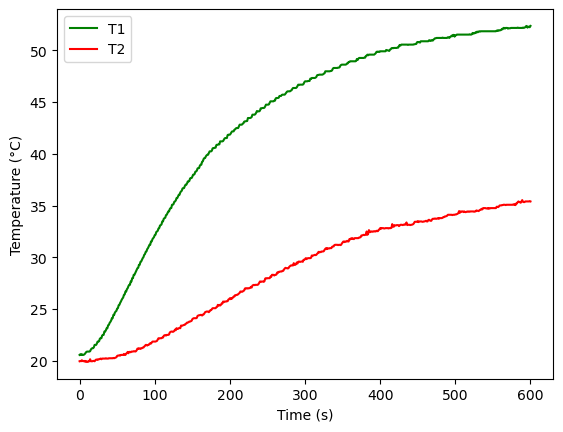

In [35]:
plt.plot(time, T1,'g-', label='T1')
plt.plot(time, T2,'r-', label='T2')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

This curve can also be converted into a dataframe and saved as an Excel file (.csv also possible):

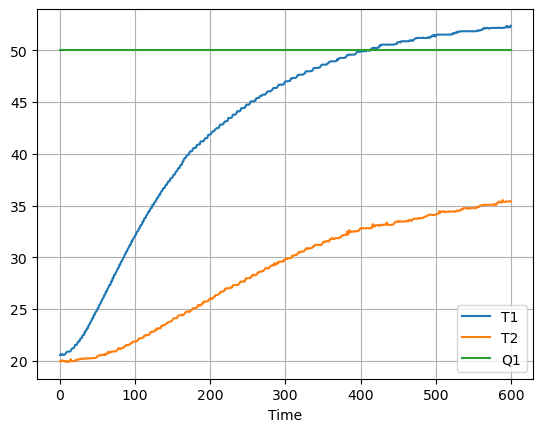

In [37]:
import pandas as pd

# Dataframe creation
df = pd.DataFrame([time, T1, T2, Q1]).T
df.columns = ['Time', 'T1', 'T2', 'Q1']
df = df.set_index('Time')

# Dataframe plot
df.plot(grid=True)

# Save the dataframe into a .csv file
df.to_csv('./data/Step_Test_Data.csv')


## Fitting the Step Change Data to a First Order Model

For a first-order linear system initially at steady-state, the response to a step input change at $t=0$ is given by

$$y(t) = y(0) + K(1 - e^{-t/\tau}) \Delta U$$

where $\Delta U$ is the magnitude of the step change. Converting to notation used for the temperature control lab where $y(t) = T_1(t)$ and $\Delta U = \Delta Q_1$

$$T_1(t) = T_1(0) + K_1(1 - e^{-t/\tau_1}) \Delta Q_1$$

> **Questions:** 
>- Recall the differential equation and the transfer function of a 1st order SISO (Single Input Single Output) dynamic system. Use notations compatible with the description of the step response above. 
> - Identify the steady state gain $K_1$ and time constant $\tau_1$
>- Compare the 1st order response with the measured data. Conclusion.

K1 is approximately : 0.64 °C/%
tau1 is approximately 182.01 seconds


Text(0.5, 1.0, 'Residual Error')

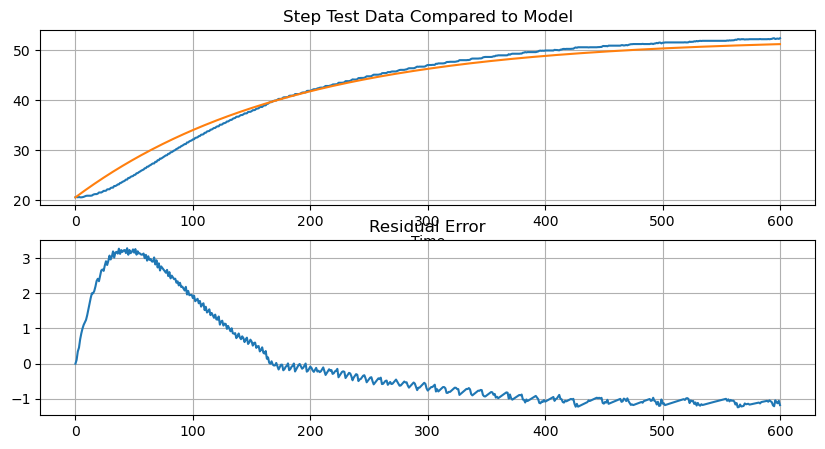

In [39]:
%matplotlib inline
import pandas as pd

# Read data
df = pd.read_csv('./data/Step_Test_Data.csv') # my data

df = df.set_index('Time')

T1 = df['T1']
Q1 = df['Q1']

# Static gain
DeltaT1 = max(T1) - min(T1)
DeltaQ1 = Q1.mean()

K1 = DeltaT1/DeltaQ1
print('K1 is approximately : %.2f °C/%%'%K1)

# find when the increase in T1 gets larger than 63.2% of the final increase
i = (T1 - T1.min()) > 0.632*(T1.max()-T1.min())
tau1 = T1.index[i].min()
print("tau1 is approximately", tau1, "seconds")

import matplotlib.pyplot as plt
import numpy as np

exp = np.exp
t = df.index

T1_est = T1.min() + K1*(1 - exp(-t/tau1))*DeltaQ1

plt.figure(figsize=(10,5))
ax = plt.subplot(2,1,1)
df['T1'].plot(ax = ax, grid=True)
plt.plot(t,T1_est)
plt.title('Step Test Data Compared to Model')

plt.subplot(2,1,2)
plt.plot(t,T1_est-T1)
plt.grid()
plt.title('Residual Error')

## Nodal thermal model

We will show here that a physical model made up of thermal resistances and capacities can explain the dynamic responses observed and the transfer functions identified previously.

> **Questions:** 
>- Recall the characteristic equations for thermal resistances and capacities relating temperatures $T_i$ and heat flows (power) $P$.   
>- Select the thermal model to represent the temperature rise if we assume that the heating element and the temperature sensor are at the same temperature. 
>- Determine the values of the thermal resistance $R_{th}$ and the thermal capacity $C_{th}$ from the 1st order transfer function identified above. Assume that the maximum power of the heating element (4W) and the outside temperature are known.    
    
![Modèle thermique 1 corps](figures/Order1.png)

Thermal resistance Rth = 15.89 K/W
Thermal capcitance Cth = 11.46 J/K


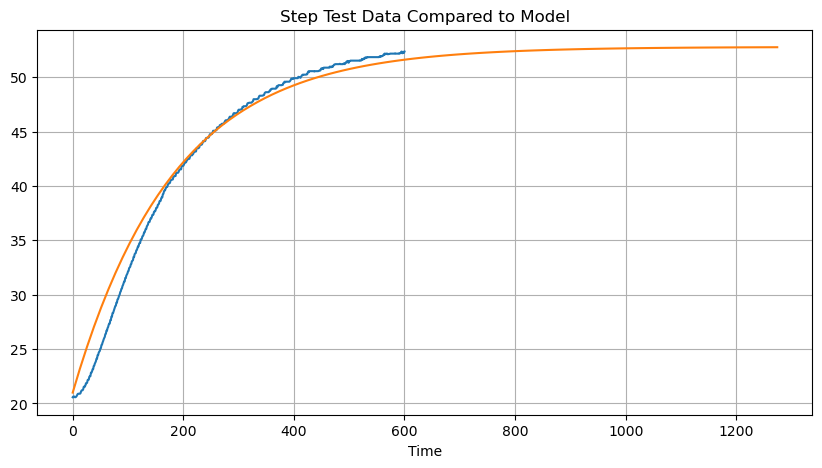

In [51]:
%matplotlib inline
import numpy as np                  # basic package for numerical calculations
import matplotlib.pyplot as plt     # plotting package
from scipy.signal import step       # Import from scipy of the step response

# parameter values and units
P1 = 0.5*4                 # watts
Rth = K1*50/P1              # watts/deg C
Cth = tau1/Rth                 # joules/deg C
T_ambient = 21         # ambient temperature

# First order step response
num = [Rth]
den = [Rth*Cth, 1]
t, y = step(system=(num, den))
T1_est = T_ambient  + P1*y

plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
df['T1'].plot(ax = ax, grid=True)
plt.plot(t,T1_est)
plt.title('Step Test Data Compared to Model')

#Print data
print("Thermal resistance Rth = %.2f K/W"%Rth)
print("Thermal capcitance Cth = %.2f J/K"%Cth)

The parameter values in the above plot were chosen to (at least roughly) reproduce the measured response of temperature control laboratory. The [specific heat capacity for solids](https://en.wikipedia.org/wiki/Heat_capacity) is typically has values in the range of 0.2 to 0.9 J/K/gram. Using a value of 0.9 that is typical of aluminum and plastics used for electronic products, the estimated mass of the heater/sensor pair would be:

In [54]:
print("Equivalent mass : %.2f g"%(Cth/0.9))

Equivalent mass : 12.73 g


## Two State Model for a Single Heater

## References 

[Hedengren] Hedengren, J., Process Dynamics and Control, Brigham Young University.  [Link](http://apmonitor.com/pdc/index.php/Main/ArduinoTemperatureControl)

[Kantor, 2021] Kantor, JC., Chemical Process Control class materials. [Link](https://jckantor.github.io/cbe30338-2021/) / [Github](https://github.com/jckantor/cbe30338-2021)